# Mastering BackProp

Read this: https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b

Usual data loading

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


# Getting into Backprop

Utility function to compare manual gradients to Torch gradients

In [4]:
# def cmp(s, dt, t):
#     ex = torch.all(dt == t.grad).item()
#     app = torch.allclose(dt, t.grad)
#     maxdiff = (dt - t.grad).abs().max().item()
#     print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

Re-using our network design. The initialisations are changed to small random numbers. Just using random numbers might result in zeros being init, which will be some sort of mask. So multiply the init vars by a small number to prevent this

In [5]:
n_embd = 10 # dimensionality of the char embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)  # Kaiming init
b1 = torch.randn(n_hidden,                      generator=g) * 0.1 # this is generally not needed, since have batchnorm but it will be used for sanity check
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.1
b2 = torch.randn(vocab_size,                    generator=g) * 0.1

# Batch Norm params
bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1
bnmean_running = torch.zeros((1, n_hidden)) # init mean should be roughly 0
bnstd_running = torch.ones((1, n_hidden))  # and std should be roughly 1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [6]:
batch_size = 32
n = batch_size

ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

We bring back an explicit implementation of the loss function. We also break down into smaller chunks with intermediate tensors so we can do backward more appropriately

In [7]:
# forward pass
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# Linear layer
hprebn = embcat @ W1 + b1

# Batchnorm layer
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1 / (n-1) * (bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non linearity
h = torch.tanh(hpreact)

# Linear layer 2
logits = h @ W2 + b2

# Cross entropy loss 
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean() # iterate down the rows and get the index specified by the element in the tensor Yb, get the mean and negate

In the backward pass, we want to retain the grads

In [8]:
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes,
          logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff, bndiff2, hprebn, bnmeani, 
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.8279, grad_fn=<NegBackward0>)

Manually backprop through all the variables

Let's say our loss is loss = -1/3a + -1/3b + -1/3c, the derivatives dloss/da = -1/3, dloss/db=-1/3, dloss/dc=-1/3. Now, if our loss has n elements, we see that the derivative essentially becomes dloss/d(n) = -1/n

i.e. for every element i in loss, dloss/di = -1/n

But logprobs is an array of shape [32, 27], but only 32 of them participate in loss calculation. The gradient of all these others is 0 because they do not participate in the loss. 

In [9]:
dlogprobs =   torch.zeros_like(logprobs) # holds the derivative of the loss wrt all elements of logprobs

# we need to set the derivatives of each element in exactly its same location
dlogprobs[range(n), Yb] = -1.0/n


# we check it using our function cmp
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


Now we are doing chain rule backwards, which means dx/dprobs = dlogprobs/dprobs * dx/dlogprobs 

dlogprobs/dprobs = d(log(probs)) = 1/probs

In [10]:
dprobs = (1.0 / probs) * dlogprobs
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


If your probs is very close to 1 (correct character getting high prob), then dprobs becomes 1/1*dlogprobs. Meaning logprobs just gets passed through. But if it is close to 0 (correct character getting low prob), then 1/~0*logprobs boosts itss gradients

# Recap the loss function and understanding how to work with counts

Let's revise the loss. We have the logits coming from the last layer, from which we find the maximum from the row. We then normalize it and exponientiate (for safety)

We exponentiate the sum of logits to create count and we normalize so all probs sum to 1

We want to backprob into counts_sum_inv and then into counts. But counts is [32,27] and counts_sum_inv is [32,1]

Due to this difference in shape, there's automatic broadcasting that looks like the following

c = a * b, where a[3x3] and b[3,1] <br>
It gets broadcast as <br>
a11*b1 a12*b1 a13*b1 <br>
a21*b2 ..     a23*b2 <br>
a31*b3  ..    a33*b3  <br>
c[3x3]

When calculating the derivative, we need to consider the sequential operations done in this broadcast. 1) PyTorch replicates the vector b across all the rows; and 2) the multiplication <br>
We first backprob through the multiplication <br>

Let's look at it as scalars c = a * b <br>
dc/db = a <br>

Applying this logic on probs = counts * counts_sum_inv, <br>
dloss/dcounts_sum_inv = dloss/dprobs * dprobs/dcounts_sum_inv <br>
= dprobs * counts

Since counts_sum_inv is the repeated vector (broadcast), its gradients are summed up to the current node at which we are backproping

In [11]:
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)


counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


Now we backprob into the other variable counts i.e dc/da = b

In [12]:
dcounts = counts_sum_inv * dprobs 

counts_sum_inv depends on count in an extra dependency through counts_sum. This creates a second branch of counts, and so we cannot directly verify cmp(counts)

counts_sum_inv = counts_sum^-1 = 1/counts_sum <br>
dloss/dcounts_sum = dloss/dcounts_sum_inv * dcounts_sum_inv/dcounts_sum <br>

But d(1/x) = -1/(x)^2 <br>
dcounts_sum = dcounts_sum_inv * -1/(counts_sum)^2

In [13]:
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv 

cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


We now go to counts_sum = counts.sum(1, ...)

We are summing counts.sum along the rows. This means counts [32,27] is summed into counts_sum [32, 1]. Essentially looks like <br>
a11 a12 a13 ---> b1 (= a11 +...+ a13) <br>
a21 ..  a23 ---> b2 (= a21 +...+ a23) <br>
a31 ..  a33 ---> b3 (= a31 +...+ a33)

We need to expand counts_sum col into a 2D array. We have the derivatives wrt b i.e we dcounts_sum. We want this derivative wrt a, i.e how does it behave wrt a

We can see b_i only depends on a_ij, where j=cols. e.g. b1 only depends on a_1j and not on a_2j or a_3j. db1 wrt to a2j and a3j is 0 (no dependency) <br>
Also, if x = y + z, where x and y are scalars, dx/dy = 1 and dx/dz = 1 <br>
This derivative of 1 basically serves as a router, taking the incoming derivative and equally re-routing it to participating elements. i.e. b_i routes the incoming derivative to a_ij

So we will be taking dcounts_sum and replicating it 27 times horizontally to create [32,27]

dcounts = torch.ones_like(counts) * dcounts_sum

But dcounts was previously calculated. so we get

In [14]:
dcounts += torch.ones_like(counts) * dcounts_sum

cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


for norm_logits, d(e^x) = e^x <br>
dloss/dnorm_logits = dloss/dcounts * dcounts/dnorm_logits <br>
dcounts/dnorm_logits = norm_logits.exp() = counts ...<br>
..because counts = norm_logits.exp() <br>
So dcounts/dnorm_logits = counts

In [15]:
dnorm_logits = counts * dcounts

cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


Now on to norm_logits = logits - logit_maxes. Here the shapes are not the same <br>
logits [32,27] and logit_maxes [32,1] 

Let's say we have c[3x3] = a[3x3] - b[3,1] <br>
Every c_ij = a_ij - b_i e.g. c_32 = a_32 - b_3 <br>
So dc_ij/da_ij = 1 and dc_ij/db_i = -1 


In [16]:
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

cmp('dlogit_maxes', dlogit_maxes, logit_maxes)

dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0


Now we backprop the second branch of logits: logit_maxes = logits.max(1, keepdim=True).values

The max function returns both the max values and the indices where it found those values. In the forward pass, we only need these max values, but in the backward pass, we also need to know those indices

In the forward pass, the max value of each row gets plucked out. In the backward pass, we need to take the dlogit_maxes and scatter it from where the max value originally came

We do a one_hot encoding, yielding a 1 where the max came from in each row and we multiply by the dlogit_maxes

In [17]:
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


# Linear Layer 2 <br>
logits = h @ W2 + b2 <br>
logits[32,27], h[32,64], W2[64,27], b2[27]

h * W2 will give a [32,27]. <br>
The rules of broadcasting means that b2 gets a padded dim becoming a row vector [1,27] <br>
This gets replicated row wise

d = a @ b + c <br>
|d11 d12| = |a11 a12| |b11 b12| + |c1 c2| <br>
|d21 d22| = |a21 a22| |b21 b22| + |c1 c2| <br>


d11 = a11b11 + a12b21 + c1 <br>
d12 = a11b12 + a12b22 + c2 <br>
d21 = a21b11 + a22b21 + c1 <br>
d22 = a21b12 + a22b22 + c2 <br>


We want dloss wrt each of the vars

dloss/da11 = dloss/d11(b11) + dloss/d11(b12) <br>
Continuing for the other vars and summarizing leaves us with <br>
dloss/da = dloss/dd @ bT <br>
dloss/db = aT @ dloss/dd <br>
dloss/dc = dloss/dd * sum(0) i.e. sum across the cols <br>

A shortcut

When we are calculating the derivatives, we need to maintain the shapes

h is a 32x64 so dh should be 32x64. But we can see that dlogits is 32x27 and W2 is 64x27 <br>
Transposing W2 gives us 27x64 and we can then see that <br>

dh = dlogits @ W2.T <br>
Similarly with W2 the shape is 64x27, which can be obtained from h's 32x64 and dlogits' 32x27 as <br>
dW2 = h.T @ dlogits <br>
And for b2, it's straightforward

In [18]:
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

cmp('dh', dh, h)
cmp('dW2', dW2, W2)
cmp('db2', db2, b2)

dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0


# Non-linearity

a = tanh(z) <br>
da/dz = 1 - a^2 <br>
Note that a is the output of tanh

In [19]:
dhpreact = (1.0 - h**2) * dh

cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


# Batchnorm Variables

hpreact = bngain * bnraw + bnbias <br>
hpreact [32,64] <br>
bngain [1,64] <br>
bnraw [32,64] <br>
bnbias [1,64] <br>

dbngain = bnraw * dhpreact <br> 
bngain needs to be of size [1,64], but bnraw * dhpreact is [32,64] <br>
So the gradients in all of those rows need to be summed up (across col) and we get

In [20]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)

dbngain         | exact: True  | approximate: True  | maxdiff: 0.0
dbnraw          | exact: True  | approximate: True  | maxdiff: 0.0
dbnbias         | exact: True  | approximate: True  | maxdiff: 0.0


For the basic elementwise multiplications, we can repeat the derivatives as we have seen

dbndiff = bnvar_inv * dbnraw <br>
dbnvar_inv = bndiff * dbnraw
But bndiff is a [32,64] and dbnraw is [32,64] and dbnvar_inv needs to match dbnvar_inv's [1,64], so we sum

In [21]:
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

cmp('dbndiff', dbndiff, bndiff)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)

dbndiff         | exact: False | approximate: False | maxdiff: 0.0012138169258832932
dbnvar_inv      | exact: True  | approximate: True  | maxdiff: 0.0


dbndiff is not correct because we still have an extra branch of it

bnvar_inv = (bnvar + 1e-5)**-0.5 <br>
d(x^n)/dx = nx^n-1 <br>

In [22]:
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

cmp('dbnvar', dbnvar, bnvar)

dbnvar          | exact: True  | approximate: True  | maxdiff: 0.0


<b>Note about broadcast and sum

We have a convention here, everytime there's a broadcast in the forward pass, it becomes a sum in the backward pass and vice versa. The broadcast indicates a variable re-use as the variable is copied multiple times. This has to be summed back to the original variable in the backward pass

bnvar = 1 / (n-1) * (bndiff2).sum(0, keepdim=True) <br>

We create an array of ones like bndiff2 and scale it

In [24]:
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar #dbnvar is broadcast

cmp('dbndiff2', dbndiff2, bndiff2)

dbndiff2        | exact: True  | approximate: True  | maxdiff: 0.0


Now at bndoff2 = bndiff**2. We have a += because we're merging the other branch of dbndiff

In [ ]:
dbndiff += (2*bndiff) * dbndiff2 

cmp('dbndiff', dbndiff, bndiff)

dbndiff         | exact: True  | approximate: True  | maxdiff: 0.0


And now on to bndiff = hprebn - bnmeani <br>
bndiff[32,64], hprebn[32,64], bnmeani[1,64] <br>
So bnmean is broadcast by the '-' operation (indicating a variable reuse). Therefore there will be a sum in the backward pass 

In [26]:
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0, keepdim=True)

cmp('dhprebn', dhprebn, hprebn)
cmp('dbnmeani', dbnmeani, bnmeani)

dhprebn         | exact: False | approximate: False | maxdiff: 0.001590285450220108
dbnmeani        | exact: True  | approximate: True  | maxdiff: 0.0


dhprebn is false because it branches. So we have to handle those branches first

bnmeani = 1/n*hprebn.sum(0, keepdim=True) <br>
Our sum becomes a broadcast

In [27]:
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

cmp('dhprebn', dhprebn, hprebn)

dhprebn         | exact: True  | approximate: True  | maxdiff: 0.0


# Linear Layer 1

hbprebn = embcat @ W1 + b1 <br>
[32,64] = [32,30] @ [30,64] + [64] <br>
We do a similar thing as in linear layer 2

In [30]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0) # we don't keepdim so we eliminate the dims of dhprebn and remain with that of db1

cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)

dembcat         | exact: True  | approximate: True  | maxdiff: 0.0
dW1             | exact: True  | approximate: True  | maxdiff: 0.0
db1             | exact: True  | approximate: True  | maxdiff: 0.0


embcat = emb.view(emb.shape[0],-1) <br>
embcat[32,30], emb[32,3,10] <br>
demb will be dembcat.view of the original

In [31]:
demb = dembcat.view(emb.shape)

cmp('demb', demb, emb)

demb            | exact: True  | approximate: True  | maxdiff: 0.0


emb = C[Xb] <br>
emb[32,3,10], C[27,10], Xb[32,3]

Recall that Xb contains integers used to lookup C. This is done by looking up the rows in C specified by values in Xb <br>
Each of the integers in Xb specify which row of C is going to be plucked out. <br>
The plucked out rows are arranged into a [32,3,10] tensor <br> 
For every plucked out row, we want to route the gradient back to its original C element. <br>
We first need to find out which row of C did every one of the embeddings come from and deposit them into the C <br>
This requires 'undoing the indexing' <br>
If any of the rows were used multiple times i.e. a value of Xb repeats itself (which is very common), the gradients have to add

In [32]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j] # we add for repeating derivatives

cmp('C', dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


# Rapid and Straightforward Backprop

Cross-Entropy

We have PyTorch's cross_entropy function. We can backprop by directly looking at the formula and getting the derivative from it

In [33]:
loss_fast =  F.cross_entropy(logits, Yb)

loss = -logP_y, where P_y is basically softmax <br>
dloss/dli = d/dli of -log(e^l_y / summation(e^l_j))

In [35]:
dlogits = F.softmax(logits, 1) # doing softmax along dims=1 ie rows
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09


This is close enough but differs because of internal floating point operations

# Understanding dlogits

In [37]:
dlogits[0] * n

tensor([ 0.0114, -0.7981,  0.0166,  0.0328,  0.0600,  0.0168,  0.0098,  0.0129,
         0.0323,  0.0222,  0.0597,  0.0070,  0.0208,  0.0054,  0.0203,  0.0195,
         0.0248,  0.0057,  0.0021,  0.0161,  0.1436,  0.0426,  0.0746,  0.0135,
         0.0041,  0.0602,  0.0630], grad_fn=<MulBackward0>)

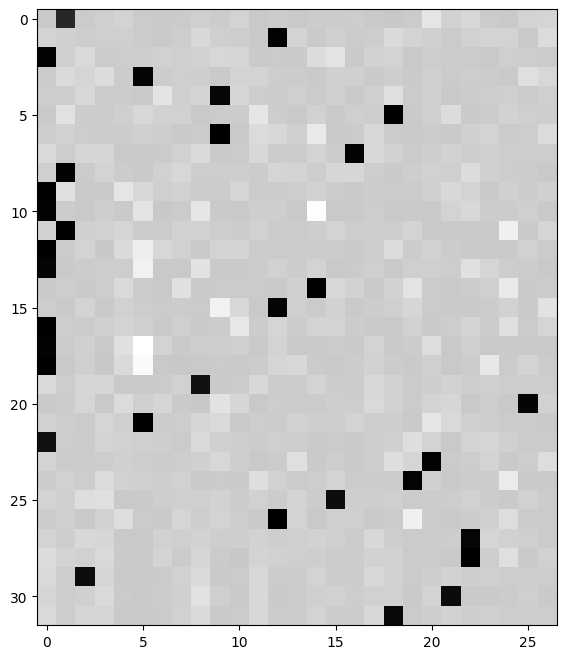

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

The black squares represent the indices of the correct probs that we subtracted a 1. <br>
The gradients can be thought of as a force pulling down on probs of incorrect chars and pushing up on those of correct chars. <br>
For each row, the amount of pull down or push up is equalized (row sums to 1). <br>
The amount of force applied in the push or pull is proportional to the probability obtained in dlogits. 

# Quick Backprop of Batch Norm

In [39]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias

In [40]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
